In [50]:
#imports 
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader,Dataset

import spacy
import statistics
import torchtext
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

In [51]:
torch.backends.cudnn.benchmark = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 128
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-5
MAX_EPOCHS = 100
NUM_GPU=1

In [64]:
class Vocabulary(object):
    def __init__(self, freq_threshold, spacy_eng=None):
        self.start_word = "<SOS>"
        self.end_word = "<EOS>"
        self.pad_word = "<PAD>"
        self.unk_word = "<UNK>"
        
        self.itos = {0: self.pad_word, 1: self.start_word, 2: self.end_word, 3: self.unk_word}
        self.stoi = {self.pad_word: 0, self.start_word: 1, self.end_word: 2, self.unk_word: 3}
        
        self.itos = {0: self.start_word, 1: self.end_word, 2: self.pad_word, 3: self.unk_word}
        self.stoi = {self.start_word: 0, self.end_word: 1, self.pad_word: 2, self.unk_word: 3}
        
        
        self.freq_threshold = freq_threshold
        if spacy_eng==None:
            self.spacy_eng = spacy.load('en_core_web_sm')
        else:
            self.spacy_eng = spacy_eng
        
    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        tokenizer = [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]
        return tokenizer
        
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, caption_delimiter='|', 
                 image_column='image_name', text_column='caption_text',
                 transform=None, freq_threshold=5,
                 train=True, split_val=0.2):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.caption_delimiter = caption_delimiter
        self.image_column = image_column
        self.text_column = text_column
        
        self.dataframe = pd.read_csv(caption_file, delimiter=caption_delimiter)
        self.transform = transform
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.dataframe[self.text_column].tolist())
        
        self.train = train 
        self.split_val = split_val
        self._do_split_train_valid()
        
    def _do_split_train_valid(self):
        imgs_train, imgs_valid, caps_train, caps_valid = train_test_split(
            self.dataframe[self.image_column], self.dataframe[self.text_column], 
            test_size=self.split_val, random_state=16
        )
        
        if self.train:
            self.imgs = imgs_train
            self.captions = caps_train
        else:
            self.imgs = imgs_valid
            self.captions = caps_valid
            
        self.imgs = self.imgs.tolist()
        self.captions = self.captions.tolist()
        

    def __len__(self):
        return len(self.imgs)
    
    def _numericalized_caption(self, caption):
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return numericalized_caption

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        ncaption = self._numericalized_caption(caption)

        return img, torch.tensor(ncaption)


class CaptionCollate:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        batch.sort(key=lambda x: len(x[1]), reverse=True)
        (images, captions) = zip(*batch)
        
        imgs = [img.unsqueeze(0) for img in images]
        imgs = torch.cat(imgs, dim=0)
        
        lengths = [len(cap) for cap in captions]
        targets = torch.zeros(len(captions), max(lengths)).long()
        for idx, cap in enumerate(captions):
            end = lengths[idx]
            targets[idx, :end] = cap[:end]
        return imgs, targets, lengths
    

def flickr8k_dataloader(root_folder, caption_file, transform, train=True,
                        batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    
    dataset = FlickrDataset(root_folder, caption_file, transform=transform, train=train)
    PAD_IDX = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers,
                            shuffle=shuffle, pin_memory=pin_memory, 
                            collate_fn=CaptionCollate(pad_idx=PAD_IDX))
    
    return dataloader, dataset

In [72]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

root_dir = "data/flickr30k/images/"
caption_file = "data/flickr30k/captions.txt"

train_loader, trainset = flickr8k_dataloader(root_dir, caption_file, transform=train_transform,  
                                             num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = flickr8k_dataloader(root_dir, caption_file, transform=valid_transform, 
                                             num_workers=NUM_WORKERS, shuffle=False, train=False)

In [73]:
img, cap = trainset[200]
print([trainset.vocab.itos[token] for token in cap.tolist()])
len(trainset), len(validset)

['<SOS>', 'crowd', 'of', 'people', 'wearing', 'blue', 'standing', 'on', 'the', 'street', 'by', 'buildings', '.', '<EOS>']


(127132, 31783)

In [74]:
imgs, caps, lengths = next(iter(valid_loader))

targets = pack_padded_sequence(caps, lengths, batch_first=True)
targets[0][0]

print([trainset.vocab.itos[token] for token in targets[0].tolist()])
print(imgs[0].shape)

['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', 'many', 'a', 'a', 'at', 'a', 'two', 'a', 'a', 'a', 'a', 'a', 'a', 'two', 'a', 'a', 'a', 'woman', 'a', 'a', 'a', 'woman', 'older', 'brown', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'two', 'various', 'member', 'woman', 'group', 'a', 'balding', 'women', 'person', 'young', 'little', 'man', 'boy', 'young', 'men', 'group', 'man', 'player', 'looking', 'red', 'group', 'woman', 'on', 'women', 'dog', 'upper', 'surfer', 'lady', 'man', 'man', 'young', 'woman', 'children', 'marathon', 'of', 'in', 'of', 'beach', 'man', 'dressed', 'painting', 'man', 'girl', 'playing', 'uses', 'bespectacled', 'climb', 'of', 'wearing', 'for', 'through', '-', 'of', 'in', 'stage', 'in', 'leaps', 'deck', 'in', 'is', 'smiling', 'is', 'girl', '

In [75]:
class Encoder(nn.Module):
    def __init__(self, embed_size, train_cnn=False, resnet_model=models.resnet50):
        super(Encoder, self).__init__()
        self.train_cnn = train_cnn
        resnet = resnet_model(pretrained=True)
        resnet = self._fine_tune(resnet)
        modules = list(resnet.children())[:-1]
        
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def _fine_tune(self, resnet):
        if self.train_cnn:
            for param in resnet.parameters():
                param.requires_grad_(True)
        else:
            for param in resnet.parameters():
                param.requires_grad_(False)
                
        return resnet
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        embed = self.bn(self.embed(features))
        return embed


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self._init_weights()
                
    def _init_weights(self):
        torch.nn.init.xavier_uniform_(self.linear.weight)
        torch.nn.init.xavier_uniform_(self.embed.weight)

    def forward(self, features, captions, lengths):
        features = features.unsqueeze(dim=1)
        
        embeddings = self.embed(captions)
        embeddings = torch.cat((features, embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    

class ImageCaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionNet, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs

In [76]:
class ImageCaptionTask(pl.LightningModule):
    def __init__(self, model, optimizers, criterion, vocab_size, scheduler=None, batch_first=True):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.vocab_size = vocab_size
        self.batch_first = batch_first
        self.metric = Accuracy()
        
    def forward(self, imgs, captions):
        outputs = self.model(imgs, captions[:-1])
        return outputs
        
    def shared_step(self, batch, batch_idx):
        imgs, captions, lengths = batch
        packed = pack_padded_sequence(captions, lengths, batch_first=self.batch_first)
        targets, _, _, _ = packed
        
        outputs = self.model(imgs, captions, lengths)
        loss = criterion(outputs, targets)
        acc = self.metric(outputs, targets)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.TrainResult(loss)
        result.log_dict({'trn_loss': loss, 'trn_acc': acc})
        
        return result
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log_dict({'val_loss': loss, 'val_acc': acc})
        
        return result
    
    def configure_optimizers(self):
        if self.scheduler:
            return [self.optimizer], [self.scheduler]
        return self.optimizer
    
  

In [77]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)
print(f'VOCAB_SIZE : {VOCAB_SIZE}')

model = ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
task = ImageCaptionTask(model, optimizer, criterion, vocab_size=VOCAB_SIZE)

VOCAB_SIZE : 7666


In [78]:
checkpoint_path = '../saved_model'
# DEFAULTS used by the Trainer
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_top_k=1,
    verbose=True,
    monitor='checkpoint_on',
    mode='min',
    prefix='flickr30k_net_'
)

tensorboard_logger = pl_loggers.TensorBoardLogger('../logs/flickr30k')

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory ../saved_model exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, gpus=NUM_GPU, logger=tensorboard_logger, checkpoint_callback=checkpoint_callback)
trainer.fit(task, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageCaptionNet  | 28 M  
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     



Epoch 00000: val_checkpoint_on reached 4.85262 (best 4.85262), saving model to ../saved_model/flickr30k_net_epoch=0.ckpt as top 1


In [49]:
saved_checkpoint_path = '../saved_model/flickr8k_net_epoch=99.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
task.load_state_dict(checkpoint['state_dict'])
# model.load_state_dict(task.model.state_dict())
# task.load_from_checkpoint(saved_checkpoint_path, optimizers=optimizer, criterion=criterion, vocab_size=VOCAB_SIZE)

<All keys matched successfully>

In [31]:
class ImageCaptionTest(object):
    def __init__(self, model, vocab, max_len=20):
        self.model = model
        self.vocab = vocab
        self.max_len = max_len
        
        self.model.eval()
        self.encoder = model.encoder
        self.decoder = model.decoder
        
    def process_sentence_list(self, sentences):
        sentence_list = []
        for sentence in sentences:
            sentence_list.append(self.clean_sentence(sentence))
        return sentence_list
    
    def clean_sentence(self, sentence_index):
        sentence = ""
        for i in sentence_index:
            word = self.vocab.itos[i]
            if (word == self.vocab.start_word):
                continue
            elif (word == self.vocab.end_word):
                break
            else:
                sentence = sentence + " " + word
        return sentence
    
    def sample(self, images, states=None):
        with torch.no_grad():
            inputs = self.encoder(images).unsqueeze(dim=1)
            sampled_ids = []
            for i in range(self.max_len):
                hiddens, states = self.decoder.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
                outputs = self.decoder.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
                _, predicted = outputs.max(1)                        # predicted: (batch_size)
                sampled_ids.append(predicted)
                inputs = self.decoder.embed(predicted)                       # inputs: (batch_size, embed_size)
                inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
            sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
            return sampled_ids.tolist()
    
    def generate_caption(self, images):
        sentences_indexs = self.sample(images)
        sentences = self.process_sentence_list(sentences_indexs)
        return sentences
    
def clean_sentence(sentence_index, vocab):
    sentence = ""
    for i in sentence_index:
        word = vocab.itos[i]
        if (word == vocab.start_word):
            continue
        elif (word == vocab.end_word):
            break
        else:
            sentence = sentence + " " + word
    return sentence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted    :  a woman in a white shirt and a woman in a black dress and a woman in a red
ground truth :  two girls doing a presentation
tensor([   0,   50,  237,  384,    4, 2252,    1])


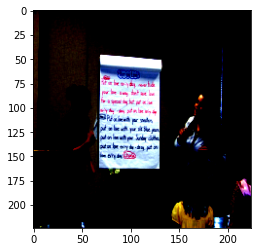

In [47]:
img, txt = validset[201]
img = img.unsqueeze(0)

image_caption = ImageCaptionTest(model, validset.vocab)
result = image_caption.generate_caption(img)


print(f'predicted    : {result[0]}')
print(f'ground truth : {clean_sentence(txt.tolist(), validset.vocab)}')
plt.imshow(img.squeeze().permute(1,2,0), cmap='gray')
print(txt)